In [8]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pandas as pd

from utils.train_evaluate import Trainer
from models.TextCNN import TextCNN
from data_ag_news.data_process.data_process_glove import DataProcess

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dp = DataProcess('../datasets/train.jsonl', '../datasets/test.jsonl', device, 128)
train_loader, test_loader = dp.get_dataLoader(141)
pre_vector = dp.get_pre_trained("../../extra/glove_vector/glove.6B.50d.txt")
print(pre_vector.shape)

torch.Size([95812, 50])


In [10]:
model = TextCNN(4, pre_vector.shape[0], pre_vector.shape[1], (3, 4, 5), (100, 100, 100))
model.embedding.weight.data.copy_(pre_vector)
model.constant_embedding.weight.data.copy_(pre_vector)  # 使用模型预训练词向量矩阵
model.constant_embedding.weight.requires_grad = False  # 冻结网络层,使之不参与训练
model = model.to(device)

epochs = 20
lr = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

In [11]:
def compute_metrics_f1(predict_all, y_true):
    """f1 score评估函数"""
    predict = predict_all.argmax(-1)
    label = y_true
    f1 = f1_score(label, predict, average='micro')
    return {"f1": f1}


t_and_v = Trainer(model=model, optimizer=optimizer, criterion=criterion, epochs=epochs)

metric_result = t_and_v.train(train_loader=train_loader, valid_loader=test_loader,
                              compute_metrics=compute_metrics_f1, verbose=200)
metric_result_df = pd.DataFrame(metric_result)
metric_result_df.index.name = 'epoch'
metric_result_df

Train Epoch: 0  [0    /120000 (0  %)]	Loss: 1.503222	f1: 0.226562
Train Epoch: 0  [25600/120000 (21 %)]	Loss: 0.705729	f1: 0.757812
Train Epoch: 0  [51200/120000 (43 %)]	Loss: 0.544632	f1: 0.820312
Train Epoch: 0  [76800/120000 (64 %)]	Loss: 0.480003	f1: 0.867188
Train Epoch: 0  [102400/120000 (85 %)]	Loss: 0.308786	f1: 0.906250
Train Epoch: 0  [120000/120000 (100%)]	Loss: 0.405403	f1: 0.859375
----------------------------------------------------------------------------------------------------
Train Epoch: 1  [0    /120000 (0  %)]	Loss: 0.558232	f1: 0.812500
Train Epoch: 1  [25600/120000 (21 %)]	Loss: 0.451228	f1: 0.843750
Train Epoch: 1  [51200/120000 (43 %)]	Loss: 0.425047	f1: 0.828125
Train Epoch: 1  [76800/120000 (64 %)]	Loss: 0.440343	f1: 0.867188
Train Epoch: 1  [102400/120000 (85 %)]	Loss: 0.391428	f1: 0.859375
Train Epoch: 1  [120000/120000 (100%)]	Loss: 0.391358	f1: 0.843750
----------------------------------------------------------------------------------------------------
Tr

,Training loss,Training f1,Validation loss,Validation f1
epoch,,,,
0,0.373835,0.879092,0.382371,0.875789
1,0.343243,0.887858,0.352862,0.883947
2,0.326783,0.890542,0.337609,0.888289
3,0.316722,0.894942,0.328322,0.892237
4,0.308951,0.897742,0.321769,0.893947
5,0.300582,0.899492,0.315094,0.895658
6,0.294366,0.901017,0.310155,0.896842
7,0.288969,0.902700,0.305732,0.898158
8,0.283723,0.904008,0.301596,0.898684


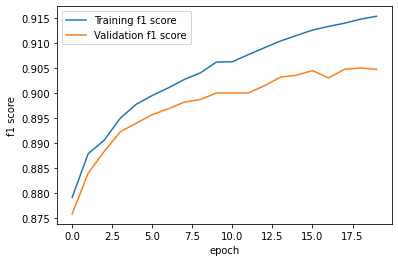

In [12]:
plt.plot(metric_result['Training f1'], label='Training f1 score')
plt.plot(metric_result['Validation f1'], label='Validation f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend()
plt.show()